### Importing libraries

In [693]:
!pip install git+https://github.com/gbolmier/funk-svd 

  Cloning https://github.com/gbolmier/funk-svd to /private/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/pip-req-build-2gj37e4y
  Running command git clone --filter=blob:none --quiet https://github.com/gbolmier/funk-svd /private/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/pip-req-build-2gj37e4y
  Resolved https://github.com/gbolmier/funk-svd to commit fecc38ea1c2859ef6a6d9af0b7f953e1b693764e
  Preparing metadata (setup.py) ... done


In [694]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt 
from funk_svd import SVD 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import textwrap as twp

### Importing Data

In [695]:
column_names = ['u_id', 'i_id', 'rating', 'timestamp']
ml1M = pd.read_csv('ratings.csv', sep=';', names=column_names)
ml1M.columns = column_names
ml1M.drop(ml1M[(ml1M['u_id'] == 'userId')].index, inplace=True)
ml1M = ml1M.astype(float)
ml1M.head()

/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/ipykernel_15853/361589548.py:2: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  ml1M = pd.read_csv('ratings.csv', sep=';', names=column_names)


,u_id,i_id,rating,timestamp
1,1.0,1193.0,5.0,978300760.0
2,1.0,661.0,3.0,978302109.0
3,1.0,914.0,3.0,978301968.0
4,1.0,3408.0,4.0,978300275.0
5,1.0,2355.0,5.0,978824291.0


In [696]:
column_names = ['u_id','gender','age','occupation','zip_code']
user_data = pd.read_csv('users1.csv', sep = ';')
user_data.columns = column_names
user_data 

,u_id,gender,age,occupation,zip_code
0,1,F,Under18,K-12student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,2460
4,5,M,25-34,writer,55455
...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603
6036,6037,F,45-49,academic/educator,76006
6037,6038,F,56+,academic/educator,14706
6038,6039,F,45-49,other,1060


### Splitting data into train, valid and test set

In [697]:
X = ml1M.drop(['rating'], axis = 1)

In [698]:
y = ml1M['rating']

In [699]:
# train_test_split
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15 
test_ratio = 0.10

# train set is 90% of the entire dataset
    # Out of train set, 15% is validation set
    # Out of train set, 75% is used for actual training
# test set is 10% of the entire dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio)
X_train ,X_val,y_train, y_val = train_test_split(X_train, y_train, test_size = validation_ratio) 


In [700]:
# concating X_train and y_train for training on SVD
X_train_svd = pd.concat([X_train, y_train], axis = 1)
X_train_svd.head() 

,u_id,i_id,timestamp,rating
522640,3224.0,2321.0,968521110.0,4.0
340407,2010.0,1459.0,974687988.0,1.0
388473,2273.0,2706.0,974568301.0,5.0
723573,4335.0,2407.0,965339084.0,3.0
676572,4055.0,3141.0,965495476.0,3.0


In [701]:
# concatinating X_val and Y_val for validating
X_val_svd = pd.concat([X_val, y_val], axis = 1) 
X_val_svd.head() 

,u_id,i_id,timestamp,rating
572679,3509.0,588.0,9.670382e+08,4.0
27507,193.0,3068.0,1.025569e+09,3.0
305825,1820.0,3697.0,9.746983e+08,4.0
337191,1983.0,15.0,9.746878e+08,4.0
401262,2391.0,1233.0,9.742963e+08,5.0


### Model One (M1) - Entirely unpruned dataset


#### Funk SVD - M1

In [702]:
def Svd(X_train, X_val, X_test, y_test): 
  svd = SVD(lr = 0.001, reg=0.005, n_epochs=150, n_factors=15, 
          early_stopping = True, shuffle = False, min_rating=1, max_rating=5)
  start = time.time()
  svd.fit(X = X_train, X_val = X_val)
  svd_Ttime = round(time.time() - start,4)
  start = time.time()
  pred = svd.predict(X_test)
  svd_Ptime = round(time.time() - start,4)
  mae = round(mean_absolute_error(y_test, pred),4)
  rmse = round(mean_squared_error(y_test, pred, squared = False),4)
  print(f'Mae is {mae} and Rmse is {rmse}')
  print(f'Training time is {svd_Ttime} and Prediction time is {svd_Ptime}')
  return mae, rmse,svd_Ttime, svd_Ptime
svd_mae_m1, svd_rmse_m1, tt_svd_m1, pt_svd_m1 = Svd(X_train_svd, X_val_svd, X_test, y_test)   

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.74 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

#### Xgboost - M1

In [703]:
def XgBoost(X_train, y_train, X_test, y_test):
    xb = XGBRegressor()
    start = time.time()
    xb.fit(X_train, y_train)
    xb_Ttime = round(time.time() - start,4)
    start = time.time()
    xb_pred = xb.predict(X_test) 
    xb_Ptime = round(time.time() - start,4) 
    xb_mae =  round(mean_absolute_error(y_test, xb_pred),4)
    xb_rmse =  round(mean_squared_error(y_test, xb_pred, squared = False),4)
    print(f'The mae is {xb_mae} and rmse is {xb_rmse}')
    print(f'Training time is {xb_Ttime} and Prediction time is {xb_Ptime}')
    return xb_mae, xb_rmse,xb_Ttime, xb_Ptime
xb_mae_m1, xb_rmse_m1, tt_xb_m1, pt_xb_m1  = XgBoost(X_train, y_train, X_test, y_test)

The mae is 0.8069 and rmse is 0.9968
Training time is 24.441 and Prediction time is 0.0611


#### Random Forest Regressor-M1

In [704]:
def Random_Forest(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor(n_estimators = 200) 
    start = time.time() 
    rf.fit(X_train, y_train)
    rf_Ttime = round(time.time() - start,4)
    start = time.time()
    rf_pred = rf.predict(X_test)
    rf_Ptime = round(time.time() - start,4) 
    rf_mae = round(mean_absolute_error(y_test, rf_pred),4) 
    rf_rmse = round(mean_squared_error(y_test, rf_pred),4)
    print(f'The mae is {rf_mae} and rmse is {rf_rmse}')
    print(f'Training time is {rf_Ttime} and Prediction time is {rf_Ptime}')
    return rf_mae, rf_rmse,rf_Ttime, rf_Ptime
rf_mae_m1, rf_rmse_m1, tt_rf_m1, pt_rf_m1 = Random_Forest(X_train, y_train, X_test, y_test) 

The mae is 0.8676 and rmse is 1.2064
Training time is 588.7413 and Prediction time is 26.9165


### Model Two (M2) - Pruning on the basis of movie ratings

#### Pruning all the movies whose ratings are less than 2 

In [705]:
# for training set 
def ratings_less_than_n(X_set, y_set, n): 
    X_set_for_pruning = pd.concat([X_set, y_set], axis = 1) 
    X_set_pruned_ratings = X_set_for_pruning[X_set_for_pruning['rating'] > n]
    y_set_pruned_ratings = X_set_pruned_ratings['rating'] 
    return X_set_pruned_ratings, y_set_pruned_ratings 
X_train_pruned_ratings,y_train_pruned_ratings = ratings_less_than_n(X_train, y_train, 2) 

In [706]:
# for validation set
X_val_pruned_ratings,y_val_pruned_ratings = ratings_less_than_n(X_val, y_val, 2) 

#### FunkSVD - M2

In [707]:
svd_mae_m2, svd_rmse_m2, tt_svd_m2, pt_svd_m2 = Svd(X_train_pruned_ratings, X_val_pruned_ratings, X_test, y_test)   

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 0.51 - val_rmse: 0.72 - val_mae: 0.58 - took 0.0 sec
Epoch 2/150  | val_loss: 0.49 - val_rmse: 0.70 - val_mae: 0.58 - took 0.0 sec
Epoch 3/150  | val_loss: 0.48 - val_rmse: 0.69 - val_mae: 0.57 - took 0.0 sec
Epoch 4/150  | val_loss: 0.47 - val_rmse: 0.69 - val_mae: 0.57 - took 0.0 sec
Epoch 5/150  | val_loss: 0.47 - val_rmse: 0.68 - val_mae: 0.57 - took 0.0 sec
Epoch 6/150  | val_loss: 0.46 - val_rmse: 0.68 - val_mae: 0.57 - took 0.0 sec
Epoch 7/150  | val_loss: 0.46 - val_rmse: 0.68 - val_mae: 0.56 - took 0.0 sec
Epoch 8/150  | val_loss: 0.46 - val_rmse: 0.68 - val_mae: 0.56 - took 0.0 sec
Epoch 9/150  | val_loss: 0.46 - val_rmse: 0.67 - val_mae: 0.56 - took 0.0 sec
Epoch 10/150 | val_loss: 0.45 - val_rmse: 0.67 - val_mae: 0.56 - took 0.0 sec
Epoch 11/150 | val_loss: 0.45 - val_rmse: 0.67 - val_mae: 0.56 - took 0.0 sec

Training took 1 sec
Mae is 0.8048 and Rmse is 1.0594
Training time is 0.5755 and Prediction tim

In [708]:
X_train_pruned_ratings.drop(['rating'], axis = 1, inplace = True) 

#### XgBoost - M2

In [709]:
xb_mae_m2, xb_rmse_m2, tt_xb_m2, pt_xb_m2= XgBoost(X_train_pruned_ratings, y_train_pruned_ratings, X_test, y_test) 

The mae is 0.843 and rmse is 1.1051
Training time is 18.2617 and Prediction time is 0.0468


#### Random Forest Regressor - M2

In [710]:
rf_mae_m2, rf_rmse_m2, tt_rf_m2, pt_rf_m2 = Random_Forest(X_train_pruned_ratings, y_train_pruned_ratings, X_test, y_test) 

The mae is 0.8778 and rmse is 1.2825
Training time is 480.6039 and Prediction time is 22.0071


### Random Pruning - M2

In [453]:
def difference(X_before, X_after):
  diff = X_before.shape[0] - X_after.shape[0] 
  return diff 
n_m2 = difference(X_train, X_train_pruned_ratings)
n_m2

125189

In [454]:
# n = number of rows to be pruned 
def random_pruning(X_set, y_set, n,s):
    X_set2 = pd.concat([X_set, y_set], axis = 1)
    np.random.seed(s) 
    drop_indices = np.random.choice(X_set2.index, n, replace=False)
    X_train_randomly_pruned = X_set2.drop(drop_indices)
    y_train_randomly_pruned = X_train_randomly_pruned['rating']
    return X_train_randomly_pruned, y_train_randomly_pruned
X_train_randomly_pruned2, y_train_randomly_pruned2 = random_pruning(X_train, y_train,n_m2,10)

In [455]:
# for validation set
n_v_m2 = difference(X_val, X_val_pruned_ratings)
n_v_m2

22264

In [456]:
# for validation set - we take n_v_m2 as we have pruned in above algorithm 
X_val_randomly_pruned2, y_val_randomly_pruned2 = random_pruning(X_val, y_val,n_v_m2,10) 

In [457]:
X_val_randomly_pruned2.shape

(112765, 4)

In [458]:
#SVD 
svd_mae_rp_m2, svd_rmse_rp_m2, tt_svd_rp_m2, pt_svd_rp_m2 = Svd(X_train_randomly_pruned2, X_val_randomly_pruned2, X_test, y_test)   

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.05 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 2/150  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 3/150  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.78 - took 0.0 sec
Epoch 4/150  | val_loss: 0.91 - val_rmse: 0.96 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 6/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 8/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 11/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [459]:
X_train_randomly_pruned2.drop(['rating'], axis = 1, inplace = True) 

In [460]:
#XgBoost
xb_mae_rp_m2, xb_rmse_rp_m2, tt_xb_rp_m2, pt_xb_rp_m2 = XgBoost(X_train_randomly_pruned2, y_train_randomly_pruned2, X_test, y_test)  

The mae is 0.8034 and rmse is 0.9897
Training time is 8.6345 and Prediction time is 0.0339


In [461]:
#Random Forest Regressor
rf_mae_rp_m2, rf_rmse_rp_m2, tt_rf_rp_m2, pt_rf_rp_m2 = Random_Forest(X_train_randomly_pruned2, y_train_randomly_pruned2, X_test, y_test)  

The mae is 0.8617 and rmse is 1.1858
Training time is 293.4973 and Prediction time is 18.0902


#### Pruning all the movies whose ratings are less than 3

In [462]:
# calling the function for pruning 
# training data 
X_train_pruned_ratings_3, y_train_pruned_ratings_3 = ratings_less_than_n(X_train, y_train, 3) 

In [463]:
# validation data 
X_val_pruned_ratings_3, y_val_pruned_ratings_3 = ratings_less_than_n(X_val, y_val, 3)

In [464]:
#SVD
svd_mae_m2_3, svd_rmse_m2_3, tt_svd_m2_3, pt_svd_m2_3 = Svd(X_train_pruned_ratings_3, X_val_pruned_ratings_3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.46 - took 0.0 sec
Epoch 2/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.45 - took 0.0 sec
Epoch 3/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec
Epoch 4/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec
Epoch 5/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.43 - took 0.0 sec
Epoch 6/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.43 - took 0.0 sec
Epoch 7/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.43 - took 0.0 sec
Epoch 8/150  | val_loss: 0.21 - val_rmse: 0.45 - val_mae: 0.42 - took 0.0 sec
Epoch 9/150  | val_loss: 0.21 - val_rmse: 0.45 - val_mae: 0.42 - took 0.0 sec

Training took 0 sec
Mae is 1.0112 and Rmse is 1.3193
Training time is 0.2498 and Prediction time is 0.1326


In [465]:
X_train_pruned_ratings_3.drop(['rating'], axis = 1, inplace = True) 

In [466]:
#XgBoost
xb_mae_m2_3, xb_rmse_m2_3,tt_xb_m2_3, pt_xb_m2_3 = XgBoost(X_train_pruned_ratings_3, y_train_pruned_ratings_3, X_test, y_test) 

The mae is 1.0334 and rmse is 1.3321
Training time is 6.4456 and Prediction time is 0.0324


In [467]:
#Random Forest Regressor
rf_mae_m2_3, rf_rmse_m2_3,tt_rf_m2_3, pt_rf_m2_3 = Random_Forest(X_train_pruned_ratings_3, y_train_pruned_ratings_3, X_test, y_test) 

The mae is 1.0173 and rmse is 1.7842
Training time is 196.4779 and Prediction time is 5.9292


### Model Three (M3) - Pruning on the basis of user ratings

#### Pruning users who have rated less than 30 movies

In [711]:
# count of both train and validation set is taken as common-
counts = X_train['u_id'].value_counts() 

def total_rating_less_than_n(X_set, y_set, counts, n):
    X_set_for_pruning_30 = pd.concat([X_set, y_set], axis = 1) 
    set_pruned_30 = X_set_for_pruning_30.loc[X_set_for_pruning_30['u_id'].isin(counts.index[counts > n])]
    y_set_pruned_30 = set_pruned_30['rating']
    return set_pruned_30, y_set_pruned_30
train_pruned_30, y_train_pruned_30 = total_rating_less_than_n(X_train, y_train,counts, 30)

In [712]:
val_pruned_30, y_val_pruned_30 = total_rating_less_than_n(X_val, y_val,counts, 30)

In [713]:
train_pruned_30.shape

(736462, 4)

In [714]:
val_pruned_30.shape

(129563, 4)

#### FunkSVD - M3

In [715]:
svd_mae_m3, svd_rmse_m3, tt_svd_m3, pt_svd_m3 = Svd(train_pruned_30, val_pruned_30, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 7/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.84 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [716]:
train_pruned_30.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M3

In [717]:
xb_mae_m3, xb_rmse_m3, tt_xb_m3, pt_xb_m3 = XgBoost(train_pruned_30, y_train_pruned_30, X_test, y_test)

The mae is 0.8089 and rmse is 0.998
Training time is 20.283 and Prediction time is 0.0526


#### Random Forest Regressor - M3

In [718]:
rf_mae_m3, rf_rmse_m3, tt_rf_m3, pt_rf_m3  = Random_Forest(train_pruned_30, y_train_pruned_30, X_test, y_test)

The mae is 0.8681 and rmse is 1.2065
Training time is 575.8426 and Prediction time is 30.2145


### Random Pruning - M3


In [476]:
n_m3 = difference(X_train, train_pruned_30) 
n_m3

28302

In [477]:
X_train_randomly_pruned3, y_train_randomly_pruned3 = random_pruning(X_train, y_train,n_m3,10) 

In [478]:
X_train_randomly_pruned3.shape

(736857, 4)

In [479]:
n_v_m3 = difference(X_val, val_pruned_30)

In [480]:
X_val_randomly_pruned3, y_val_randomly_pruned3 = random_pruning(X_val, y_val,n_v_m3,10)

In [481]:
X_val_randomly_pruned3.shape 

(129780, 4)

In [482]:
#SVD
svd_mae_rp_m3, svd_rmse_rp_m3,tt_svd_rp_m3, pt_svd_rp_m3 = Svd(X_train_randomly_pruned3, X_val_randomly_pruned3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [483]:
X_train_randomly_pruned3.drop(['rating'], axis = 1, inplace = True)

In [484]:
# Xgboost
xb_mae_rp_m3, xb_rmse_rp_m3, tt_xb_rp_m3, pt_xb_rp_m3 = XgBoost(X_train_randomly_pruned3, y_train_randomly_pruned3, X_test, y_test) 

The mae is 0.8062 and rmse is 0.9942
Training time is 11.5239 and Prediction time is 0.0549


In [485]:
#Random Forest Regressor
rf_mae_rp_m3, rf_rmse_rp_m3, tt_rf_rp_m3, pt_xb_rp_m3 = Random_Forest(X_train_randomly_pruned3, y_train_randomly_pruned3, X_test, y_test) 

The mae is 0.8616 and rmse is 1.1856
Training time is 354.8865 and Prediction time is 20.0787


#### Pruning users who have rated less than 40 movies

In [486]:
train_pruned_40, y_train_pruned_40 = total_rating_less_than_n(X_train, y_train,counts, 40)

In [487]:
val_pruned_40, y_val_pruned_40 = total_rating_less_than_n(X_val, y_val,counts, 40)

In [488]:
#SVD
svd_mae_m3_40, svd_rmse_m3_40, tt_svd_m3_40, pt_svd_m3_40 = Svd(train_pruned_40, val_pruned_40, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.89 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 5/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 7/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 9/150  | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.84 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.84 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [489]:
train_pruned_40 = train_pruned_40.drop(['rating'], axis = 1) 

In [490]:
#XgBoost
xb_mae_m3_40, xb_rmse_m3_40,tt_xb_m3_40, pt_xb_m3_40 = XgBoost(train_pruned_40, y_train_pruned_40, X_test, y_test)

The mae is 0.8027 and rmse is 0.9896
Training time is 9.4962 and Prediction time is 0.0319


In [491]:
#Random Forest
rf_mae_m3_40, rf_rmse_m3_40, tt_rf_m3_40, pt_rf_m3_40 = Random_Forest(train_pruned_40, y_train_pruned_40, X_test, y_test)

The mae is 0.8606 and rmse is 1.182
Training time is 838.2211 and Prediction time is 20.0919


### Model Four (M4) - Pruning data on the basis of timestamp
#### The MovieLens1M dataset consists of data between 1997 and 2003.

#### Pruning data for initial 4 months

In [787]:
len(X_train)

765159

In [788]:
from datetime import datetime 
Timestamp = X_train['timestamp'].sort_values(ascending = True)  
Timestamp[:300000] 


/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/ipykernel_15853/3011600169.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Timestamp[:300000]


999874     956703954.0
1000008    956703977.0
1000193    956703977.0
999921     956704056.0
999981     956704056.0
              ...     
556361     967396919.0
556347     967396945.0
556090     967396948.0
556068     967396948.0
556043     967396948.0
Name: timestamp, Length: 300000, dtype: float64

In [789]:
ts = int("956703932") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

04-25-2000


In [790]:
ts = int("967396948")  
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

08-27-2000


In [791]:
timestamp1 = 967396948
def timestamp_n(X_train_timestamp, y_train, timestamp): 
  # concating X_train and y_train 
  X_train_timestamp_for_pruning = pd.concat([X_train_timestamp, y_train], axis = 1)
  # pruning train data 
  X_train_timestamp_pruned = X_train_timestamp_for_pruning[X_train_timestamp_for_pruning['timestamp'] > timestamp] 
  y_train_timestamp_pruned = X_train_timestamp_pruned['rating']
  X_train_timestamp_pruned.columns = ['u_id','i_id','timestamp','rating'] 
  return X_train_timestamp_pruned, y_train_timestamp_pruned
X_train_timestamp_pruned, y_train_timestamp_pruned = timestamp_n(X_train, y_train, timestamp1)

In [792]:
# for validation set 
X_val_timestamp_pruned, y_val_timestamp_pruned = timestamp_n(X_val, y_val, timestamp1) 

#### FunkSVD - M4

In [793]:
svd_mae_m4, svd_rmse_m4, tt_svd_m4, pt_svd_m4 = Svd(X_train_timestamp_pruned, X_val_timestamp_pruned, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.07 - val_rmse: 1.03 - val_mae: 0.85 - took 0.0 sec
Epoch 2/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 3/150  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 4/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 5/150  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 6/150  | val_loss: 0.89 - val_rmse: 0.95 - val_mae: 0.75 - took 0.1 sec
Epoch 7/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.1 sec
Epoch 8/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.74 - took 0.1 sec
Epoch 9/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.1 sec
Epoch 10/150 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.1 sec
Epoch 11/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 12/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 13/150 | val

In [794]:
X_train_timestamp_pruned.drop(['rating'],axis = 1, inplace = True) 

#### XgBoost - M4

In [795]:
xb = XGBRegressor()
start = time.time() 
xb.fit(X_train_timestamp_pruned, y_train_timestamp_pruned)
tt_xb_m4 = round(time.time() - start, 4)
start = time.time()
xb_pred = xb.predict(X_test)  
pt_xb_m4 = round(time.time() - start, 4)
xb_mae_m4 =  round(mean_absolute_error(y_test, xb_pred),4)
xb_rmse_m4 =  round(mean_squared_error(y_test, xb_pred, squared = False),4)
print(f'Mae is {xb_mae_m4} and Rmse is {xb_rmse_m4}') 
print(f'Training time is {tt_xb_m4} and Prediction time is {pt_xb_m4}')


Mae is 0.8327 and Rmse is 1.0353
Training time is 15.0899 and Prediction time is 0.0739


#### Random Forest Regressor - M4

In [796]:
rf_mae_m4, rf_rmse_m4, tt_rf_m4, pt_rf_m4   = Random_Forest(X_train_timestamp_pruned, y_train_timestamp_pruned, X_test, y_test)

The mae is 0.8762 and rmse is 1.2153
Training time is 349.6351 and Prediction time is 11.5661


### Random Pruning-M4

In [797]:
n_m4 = difference(X_train, X_train_timestamp_pruned) 
n_m4

300001

In [798]:
X_train_randomly_pruned4, y_train_randomly_pruned4 = random_pruning(X_train, y_train,n_m4,10) 

In [799]:
X_train_randomly_pruned4.shape

(465158, 4)

In [824]:
n_v_m4 = difference(X_val, X_val_timestamp_pruned)
n_v_m4

52815

In [801]:
X_val_randomly_pruned4, y_val_randomly_pruned4 = random_pruning(X_val, y_val,n_v_m4,10)

In [802]:
X_val_randomly_pruned4.shape

(82214, 4)

In [803]:
#SVD
svd_mae_rp_m4, svd_rmse_rp_m4,tt_svd_rp_m4, pt_svd_rp_m4 = Svd(X_train_randomly_pruned4, X_val_randomly_pruned4, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 2/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 3/150  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 4/150  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.78 - took 0.0 sec
Epoch 5/150  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 6/150  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 7/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 8/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 9/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 10/150 | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 11/150 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 12/150 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 13/150 | val

In [804]:
X_train_randomly_pruned4.drop(['rating'], axis = 1, inplace = True) 

In [805]:
#XgBoost
xb_mae_rp_m4, xb_rmse_rp_m4, tt_xb_rp_m4, pt_xb_rp_m4 = XgBoost(X_train_randomly_pruned4, y_train_randomly_pruned4, X_test, y_test) 

The mae is 0.8115 and rmse is 1.0015
Training time is 15.15 and Prediction time is 0.0601


In [806]:
#Random Forest Regressor
rf_mae_rp_m4, rf_rmse_rp_m4, tt_rf_rp_m4, pt_rf_rp_m4 = Random_Forest(X_train_randomly_pruned4, y_train_randomly_pruned4, X_test, y_test) 

The mae is 0.8686 and rmse is 1.2052
Training time is 340.5882 and Prediction time is 17.6488


#### Puning data for initial 6 months


In [807]:
from datetime import datetime 
Timestamp = X_train['timestamp'].sort_values(ascending = True)  
Timestamp[:520000] 

/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/ipykernel_15853/1723413462.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Timestamp[:520000]


999874     956703954.0
1000008    956703977.0
1000193    956703977.0
999921     956704056.0
999981     956704056.0
              ...     
272944     974805774.0
273069     974805774.0
272902     974805774.0
273098     974805795.0
273164     974805795.0
Name: timestamp, Length: 520000, dtype: float64

In [808]:
ts = int("956703932") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

04-25-2000


In [809]:
ts = int("974805795") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

11-21-2000


In [810]:
# for training data
timestamp2 = 974805795
X_train_timestamp_pruned_3, y_train_timestamp_pruned_3 = timestamp_n(X_train, y_train, timestamp2)

In [811]:
# for validation data
X_val_timestamp_pruned_3, y_val_timestamp_pruned_3 = timestamp_n(X_val, y_val, timestamp2)

In [812]:
# SVD 
svd_mae_m4_t2, svd_rmse_m4_t2, tt_svd_m4_t2, pt_svd_m4_t2 = Svd(X_train_timestamp_pruned_3, X_val_timestamp_pruned_3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.11 - val_rmse: 1.05 - val_mae: 0.87 - took 0.0 sec
Epoch 2/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 3/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 4/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 5/150  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.78 - took 0.0 sec
Epoch 6/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 7/150  | val_loss: 0.91 - val_rmse: 0.96 - val_mae: 0.76 - took 0.0 sec
Epoch 8/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 9/150  | val_loss: 0.89 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 10/150 | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 11/150 | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 12/150 | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 13/150 | val

In [813]:
X_train_timestamp_pruned_3.drop(['rating'],axis = 1, inplace = True) 

In [814]:
# Xgboost 
xb = XGBRegressor()
xb.fit(X_train_timestamp_pruned_3, y_train_timestamp_pruned_3)
xb_pred = xb.predict(X_test)
xb_mae_m4_t2 =  round(mean_absolute_error(y_test, xb_pred),4)
xb_rmse_m4_t2  =  round(mean_squared_error(y_test, xb_pred, squared = False),4)
print(xb_mae_m4_t2, xb_rmse_m4_t2 ) 


0.9429 1.1477


In [815]:
# Random Forest Regressor
rf_mae_m4_t2, rf_rmse_m4_t2,tt_rf_m4_t2, pt_rf_m4_t2 = Random_Forest(X_train_timestamp_pruned, y_train_timestamp_pruned, X_test, y_test)

The mae is 0.877 and rmse is 1.2176
Training time is 336.7358 and Prediction time is 15.0182


### Model five (M5) - Pruning users whose occupation is 'other'

In [619]:
def prune_other(X_set, y_set):
   X_train_other = pd.concat([X_set, y_set], axis = 1)
   output = np.where(user_data['occupation'] == 'other')
   X_train_other1 = X_train_other[~X_train_other.u_id.isin(output[0])]
   y_train_other1 = X_train_other1['rating']
   return X_train_other1, y_train_other1  
X_train_other1, y_train_other1 = prune_other(X_train, y_train)

In [620]:
# For validation set
X_val_other1, y_val_other1 = prune_other(X_val, y_val) 

#### FunkSVD - M5

In [621]:
svd_mae_m5, svd_rmse_m5, tt_svd_m5, pt_svd_m5 = Svd(X_train_other1, X_val_other1, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [622]:
X_train_other1.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M5

In [623]:
xb_mae_m5, xb_rmse_m5, tt_xb_m5, pt_xb_m5 = XgBoost(X_train_other1, y_train_other1, X_test, y_test) 

The mae is 0.8071 and rmse is 0.9956
Training time is 20.3223 and Prediction time is 0.0732


#### Random Forest Regressor - M5

In [526]:
rf_mae_m5, rf_rmse_m5, tt_rf_m5, pt_rf_m5 = Random_Forest(X_train_other1, y_train_other1, X_test, y_test) 

The mae is 0.8618 and rmse is 1.1852
Training time is 519.0091 and Prediction time is 25.0213


### Random Pruning - M5

In [527]:
n_m5 = difference(X_train, X_train_other1) 
n_m5

78326

In [528]:
X_train_randomly_pruned5, y_train_randomly_pruned5 = random_pruning(X_train, y_train,n_m5,10) 

In [529]:
X_train_randomly_pruned5.shape

(686833, 4)

In [530]:
n_v_m5 = difference(X_val, X_val_other1)
n_v_m5

13748

In [531]:
X_val_randomly_pruned5, y_val_randomly_pruned5 = random_pruning(X_val, y_val,n_v_m5,10)

In [532]:
X_val_randomly_pruned5.shape 

(121281, 4)

In [533]:
#SVD
svd_mae_rp_m5, svd_rmse_rp_m5, tt_svd_rp_m5, pt_svd_rp_m5 = Svd(X_train_randomly_pruned5, X_val_randomly_pruned5, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.93 - val_rmse: 0.97 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [534]:
X_train_randomly_pruned5.drop(['rating'], axis = 1, inplace = True) 

In [535]:
#XgBoost
xb_mae_rp_m5, xb_rmse_rp_m5, tt_xb_rp_m5, pt_xb_rp_m5 = XgBoost(X_train_randomly_pruned5, y_train_randomly_pruned5, X_test, y_test) 

The mae is 0.8015 and rmse is 0.9883
Training time is 19.1195 and Prediction time is 0.0543


In [536]:
#Random Forest Regressor
rf_mae_rp_m5, rf_rmse_rp_m5, tt_rf_rp_m5, pt_rf_rp_m5 = Random_Forest(X_train_randomly_pruned5, y_train_randomly_pruned5, X_test, y_test) 

The mae is 0.8622 and rmse is 1.1871
Training time is 516.1707 and Prediction time is 24.2644


### Model Six (M6) - Pruning users whose age is less than 18

In [624]:
def prune_less_than_18(X_set, y_set):
   X_train_other = pd.concat([X_set, y_set], axis = 1)
   output = np.where(user_data['age'] == 'Under18')
   X_train_age = X_train_other[~X_train_other.u_id.isin(output[0])]
   y_train_age = X_train_age['rating']
   return X_train_age, y_train_age
X_train_18, y_train_18 = prune_less_than_18(X_train, y_train)

In [625]:
X_train_18.shape 

(737099, 4)

In [626]:
X_train.shape

(765159, 3)

In [627]:
# For validation set 
X_val_18, y_val_18 = prune_less_than_18(X_val, y_val) 

#### FunkSVD - M6

In [628]:
svd_mae_m6, svd_rmse_m6, tt_svd_m6, pt_svd_m6= Svd(X_train_18, X_val_18, X_test, y_test)  

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.74 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [629]:
X_train_18.drop(['rating'], axis = 1, inplace = True) 

#### XgBoost - M6

In [630]:
xb_mae_m6, xb_rmse_m6, tt_xb_m6, pt_xb_m6 = XgBoost(X_train_18, y_train_18, X_test, y_test) 

The mae is 0.8055 and rmse is 0.9929
Training time is 24.5854 and Prediction time is 0.078


#### Random Forest Regressor  - M6

In [544]:
rf_mae_m6, rf_rmse_m6, tt_rf_m6, pt_rf_m6 = Random_Forest(X_train_18, y_train_18, X_test, y_test) 

The mae is 0.8621 and rmse is 1.186
Training time is 556.9747 and Prediction time is 26.1307


### Random Pruning - M6

In [545]:
n_m6 = difference(X_train, X_train_18) 
n_m6

28060

In [546]:
X_train_randomly_pruned6, y_train_randomly_pruned6 = random_pruning(X_train, y_train, n_m6,10) 

In [547]:
X_train_randomly_pruned6.shape 

(737099, 4)

In [548]:
n_v_m6 = difference(X_val, X_val_18) 
n_v_m6

4844

In [549]:
X_val_randomly_pruned6, y_val_randomly_pruned6 = random_pruning(X_val, y_val, n_v_m6,10)

In [550]:
X_val_randomly_pruned6.shape 

(130185, 4)

In [551]:
svd_mae_rp_m6, svd_rmse_rp_m6, tt_svd_rp_m6, pt_svd_rp_m6 = Svd(X_train_randomly_pruned6, X_val_randomly_pruned6, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [552]:
X_train_randomly_pruned6.drop(['rating'], axis = 1, inplace = True)

In [553]:
# XgBoost
xb_mae_rp_m6, xb_rmse_rp_m6, tt_xb_rp_m6, pt_xb_rp_m6 = XgBoost(X_train_randomly_pruned6, y_train_randomly_pruned6, X_test, y_test) 

The mae is 0.8063 and rmse is 0.9938
Training time is 20.7622 and Prediction time is 0.0629


In [554]:
# Random Forest Regressor
rf_mae_rp_m6, rf_rmse_rp_m6, tt_rf_rp_m6, pt_rf_rp_m6 = Random_Forest(X_train_randomly_pruned6, y_train_randomly_pruned6, X_test, y_test) 

The mae is 0.8613 and rmse is 1.1854
Training time is 557.926 and Prediction time is 26.125


###  Model Seven(M7) - Pruning users who have rated 1 or 5 more than twice of other ratings(2,3,4)

In [657]:
def pruning_twice_more(X_set, y_set, n):
    X_train_twice = pd.concat([X_set, y_set], axis = 1) 
    X_train_twice1 = X_train_twice.groupby(['u_id','rating'])['rating'].count()
    X_train_twice1 = X_train_twice1.unstack(level=-1)
    X_train_twice1.columns = ['rating_1','rating_2','rating_3','rating_4','rating_5']
    X_train_twice1 = X_train_twice1.reset_index()
    X_train_twice1 = X_train_twice1.fillna(0).astype({"rating_1":"int","rating_2":"int","rating_3":"int","rating_4":"int", "rating_5":"int"})
    # Select rows where rating_1 is at least twice as large as the other rating columns
    df_filtered_1 = X_train_twice1[X_train_twice1['rating_1'] >= n*(X_train_twice1[['rating_2', 'rating_3', 'rating_4', 'rating_5']]).max(axis=1)]
    # Select rows where rating_5 is at least twice as large as the other rating columns
    df_filtered_5 = X_train_twice1[X_train_twice1['rating_5'] >= n*(X_train_twice1[['rating_2', 'rating_3', 'rating_4', 'rating_1']]).max(axis=1)] 
    u_id_values_rating1 = list(df_filtered_1['u_id'])
    u_id_values_rating5 = list(df_filtered_5['u_id'])
    # X_train_pruned_twice = pd.concat([X_train, y_train], axis = 1) 
    # Pruning the data where u_id is same as the values in u_id_values_rating1 and u_id_values_rating5
    X_train_pruned_twice = X_train_twice[~X_train_twice.u_id.isin(u_id_values_rating1)]
    X_train_pruned_twice_X = X_train_pruned_twice[~X_train_pruned_twice.u_id.isin(u_id_values_rating5)] 
    X_train_pruned_twice_y = X_train_pruned_twice_X['rating']
    return X_train_pruned_twice_X, X_train_pruned_twice_y

X_train_pruned_twice_X, X_train_pruned_twice_y = pruning_twice_more(X_train, y_train, 2) 

In [658]:
X_train.shape 

(765159, 3)

In [659]:
X_train_pruned_twice_X.shape

(740263, 4)

In [660]:
# pruning validation set
X_val_pruned_twice_X, X_val_pruned_twice_y = pruning_twice_more(X_val, y_val, 2)

#### FunkSVD - M7

In [661]:
svd_mae_m7, svd_rmse_m7, tt_svd_m7, pt_svd_m7  = Svd(X_train_pruned_twice_X, X_val_pruned_twice_X, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 2/150  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.78 - took 0.0 sec
Epoch 3/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 4/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 5/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 6/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 7/150  | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 8/150  | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 9/150  | val_loss: 0.84 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 10/150 | val_loss: 0.84 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.84 - val_rmse: 0.91 - val_mae: 0.72 - took 0.0 sec
Epoch 12/150 | val_loss: 0.83 - val_rmse: 0.91 - val_mae: 0.72 - took 0.0 sec
Epoch 13/150 | val

In [662]:
X_train_pruned_twice_X.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M7

In [663]:
xb_mae_m7, xb_rmse_m7, tt_xb_m7, pt_xb_m7 = XgBoost(X_train_pruned_twice_X, X_train_pruned_twice_y, X_test, y_test)

The mae is 0.8058 and rmse is 0.9929
Training time is 21.7989 and Prediction time is 0.057


#### Random Forest Regressor - M7


In [562]:
rf_mae_m7, rf_rmse_m7, tt_rf_m7, pt_rf_m7 = Random_Forest(X_train_pruned_twice_X, X_train_pruned_twice_y, X_test, y_test) 

The mae is 0.8609 and rmse is 1.1829
Training time is 581.4081 and Prediction time is 26.6216


### Random Pruning -M7

In [664]:
n_m7 = difference(X_train, X_train_pruned_twice_X) 
n_m7

24896

In [665]:
X_train_randomly_pruned7, y_train_randomly_pruned7 = random_pruning(X_train, y_train, n_m7,10) 

In [666]:
X_train_randomly_pruned7.shape 

(740263, 4)

In [667]:
n_v_m7 = difference(X_val, X_val_pruned_twice_X) 
n_v_m7

8594

In [669]:
X_val_randomly_pruned7, y_val_randomly_pruned7 = random_pruning(X_val, y_val, n_v_m7,10)

In [670]:
X_val_randomly_pruned7.shape 

(126435, 4)

In [671]:
# SVD
svd_mae_rp_m7, svd_rmse_rp_m7, tt_svd_rp_m7, pt_svd_rp_m7 = Svd(X_train_randomly_pruned7, X_val_randomly_pruned7, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 2/150  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 3/150  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 4/150  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.76 - took 0.0 sec
Epoch 5/150  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 6/150  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 7/150  | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 8/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 9/150  | val_loss: 0.86 - val_rmse: 0.93 - val_mae: 0.74 - took 0.0 sec
Epoch 10/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 11/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 12/150 | val_loss: 0.85 - val_rmse: 0.92 - val_mae: 0.73 - took 0.0 sec
Epoch 13/150 | val

In [672]:
X_train_randomly_pruned7.drop(['rating'], axis = 1, inplace = True)

In [673]:
# XgBoost
xb_mae_rp_m7, xb_rmse_rp_m7, tt_xb_rp_m7, pt_xb_rp_m7 = XgBoost(X_train_randomly_pruned7, y_train_randomly_pruned7, X_test, y_test) 

The mae is 0.8024 and rmse is 0.989
Training time is 22.5033 and Prediction time is 0.0546


In [572]:
# Random Forest Regressor
rf_mae_rp_m7, rf_rmse_rp_m7, tt_rf_rp_m7, pt_rf_rp_m7 = Random_Forest(X_train_randomly_pruned7, y_train_randomly_pruned7, X_test, y_test) 

The mae is 0.8612 and rmse is 1.1844
Training time is 582.7257 and Prediction time is 26.9591


### Visualization for final results including Random Pruning

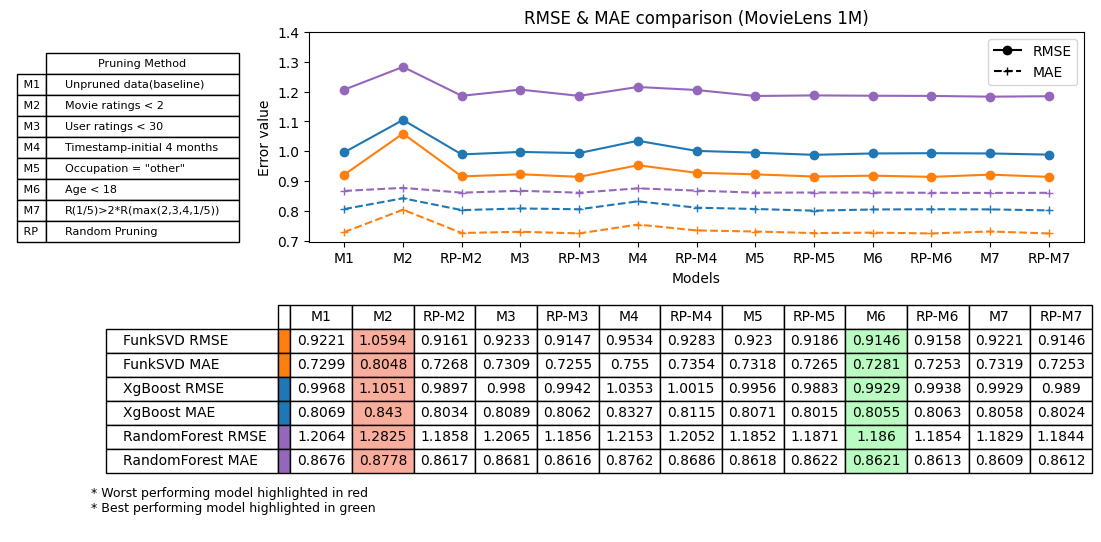

In [837]:
def visualization_results(svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5, svdrmse_rp_m5,svdrmse_m6,svdrmse_rp_m6, svdrmse_m7,svdrmse_rp_m7,
svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7,
xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7,
xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7,
rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5, rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7,
rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7):
    
    x1 = np.array(['M1','M2', 'RP-M2', 'M3', 'RP-M3', 'M4', 'RP-M4','M5','RP-M5','M6','RP-M6','M7','RP-M7'])
    y1 = np.array([svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5, svdrmse_rp_m5,svdrmse_m6,svdrmse_rp_m6,svdrmse_m7,svdrmse_rp_m7])

    y2 = np.array([svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7])

    y3 = np.array([xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7])

    y4 = np.array([xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7])

    y5 = np.array([rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5 ,rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7])

    y6 = np.array([rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7])

    # Plot 1
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'RMSE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])
    plt.title('RMSE & MAE comparison (MovieLens 1M)')
    plt.ylabel('Error value')
    plt.xlabel('Models')

    #Plot 2
    plt.subplot(2,1,1)
    plt.plot(x1, y2, '+--', label = 'MAE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])

    # Plot 3
    plt.subplot(2,1,1)
    plt.plot(x1, y3, 'o-', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])

    # Plot 4
    plt.subplot(2,1,1)
    plt.plot(x1, y4, '+--', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])

    # Plot 5
    plt.subplot(2,1,1)
    plt.plot(x1, y5, 'o-', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])

    # Plot 6
    plt.subplot(2,1,1)
    plt.plot(x1, y6, '+--', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])

    col_labels=['', 'M1', 'M2', 'RP-M2', 'M3', 'RP-M3', 'M4', 'RP-M4', 'M5','RP-M5','M6','RP-M6','M7','RP-M7']
    row_labels=['FunkSVD RMSE','FunkSVD MAE', 'XgBoost RMSE','XgBoost MAE', 'RandomForest RMSE', 'RandomForest MAE']
    colors_key_rp = [["#ff7f0e","w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#ff7f0e","w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],
    ["#1f77b4", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#1f77b4", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],
    ["#9467bd", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#9467bd", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"]]
    table_vals= [['',svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5,svdrmse_m6,svdrmse_rp_m6, svdrmse_rp_m5,svdrmse_m7,svdrmse_rp_m7],
    ['',svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7],
    ['',xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7],
    ['',xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7],
    ['',rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5,rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7],
    ['',rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7]]

    #The first coordinate is a shift on the x-axis, second coordinate is a gap between plot and text box (table in your case), 
    # third coordinate is a width of the text box, fourth coordinate is a height of text box.

    the_table = plt.table(cellText=table_vals,
         cellColours=colors_key_rp,
         rowLabels=row_labels,
         colWidths = [0.07,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35],
         colLabels=col_labels,
         cellLoc='center',
         fontsize = 30,
         loc='bottom', bbox=[-0.04, -1.1, 1.05, 0.8])

    col_labels_model=['Pruning Method']
    row_labels_model=[' M1 ', ' M2 ', ' M3 ', ' M4 ', ' M5 ',' M6 ', ' M7 ',' RP ']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 4 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))'],['Random Pruning']]

    model_table = plt.table(cellText=model_vals,
          colLabels= col_labels_model,
          rowLabels=row_labels_model,
          cellLoc = 'left',
          fontsize = 25,
          loc='left', bbox=[-0.34, 0, 0.25, 0.9])

    row_labels_key=["", "", ""]
    colors_key = [["#ff7f0e","w"],["#1f77b4", "w"],["#9467bd", "w"]]
    key_vals = [['','FunkSVD'], ['','XgBoost'], ['','RandomForest']]

    plt.annotate('* Worst performing model highlighted in red \n * Best performing model highlighted in green', 
            xy=(-0.1, 0), 
            xycoords=('axes fraction', 'figure fraction'),
            xytext=(0, 20),  
            textcoords='offset points',
            size=9, ha='center', va='bottom')
    
    legend_elements = [Line2D([0], [0], color='black', linestyle='-', marker='o'), Line2D([0], [0], color='black', linestyle='--', marker='+')]
    plt.legend(legend_elements,['RMSE','MAE'],loc ='upper right')
    plt.show()

visualization_results(svd_rmse_m1,svd_rmse_m2,svd_rmse_rp_m2,svd_rmse_m3,svd_rmse_rp_m3, svd_rmse_m4 ,svd_rmse_rp_m4, svd_rmse_m5,svd_rmse_rp_m5,svd_rmse_m6,svd_rmse_rp_m6,svd_rmse_m7,svd_rmse_rp_m7,
svd_mae_m1,svd_mae_m2,svd_mae_rp_m2,svd_mae_m3,svd_mae_rp_m3 ,svd_mae_m4, svd_mae_rp_m4,svd_mae_m5, svd_mae_rp_m5,svd_mae_m6, svd_mae_rp_m6, svd_mae_m7,svd_mae_rp_m7,
xb_rmse_m1,xb_rmse_m2,xb_rmse_rp_m2,xb_rmse_m3,xb_rmse_rp_m3, xb_rmse_m4 ,xb_rmse_rp_m4, xb_rmse_m5,xb_rmse_rp_m5,xb_rmse_m6,xb_rmse_rp_m6,xb_rmse_m7,xb_rmse_rp_m7,
xb_mae_m1,xb_mae_m2,xb_mae_rp_m2,xb_mae_m3,xb_mae_rp_m3, xb_mae_m4 ,xb_mae_rp_m4,xb_mae_m5,xb_mae_rp_m5,xb_mae_m6,xb_mae_rp_m6, xb_mae_m7,xb_mae_rp_m7,
rf_rmse_m1,rf_rmse_m2,rf_rmse_rp_m2,rf_rmse_m3, rf_rmse_rp_m3, rf_rmse_m4 ,rf_rmse_rp_m4, rf_rmse_m5, rf_rmse_rp_m5,rf_rmse_m6, rf_rmse_rp_m6,rf_rmse_m7,rf_rmse_rp_m7,
rf_mae_m1,rf_mae_m2,rf_mae_rp_m2,rf_mae_m3, rf_mae_rp_m3 ,rf_mae_m4, rf_mae_rp_m4,rf_mae_m5, rf_mae_rp_m5,rf_mae_m6, rf_mae_rp_m6,rf_mae_m7,rf_mae_rp_m7,)

### Visualisation showing data complexity and time efficiency

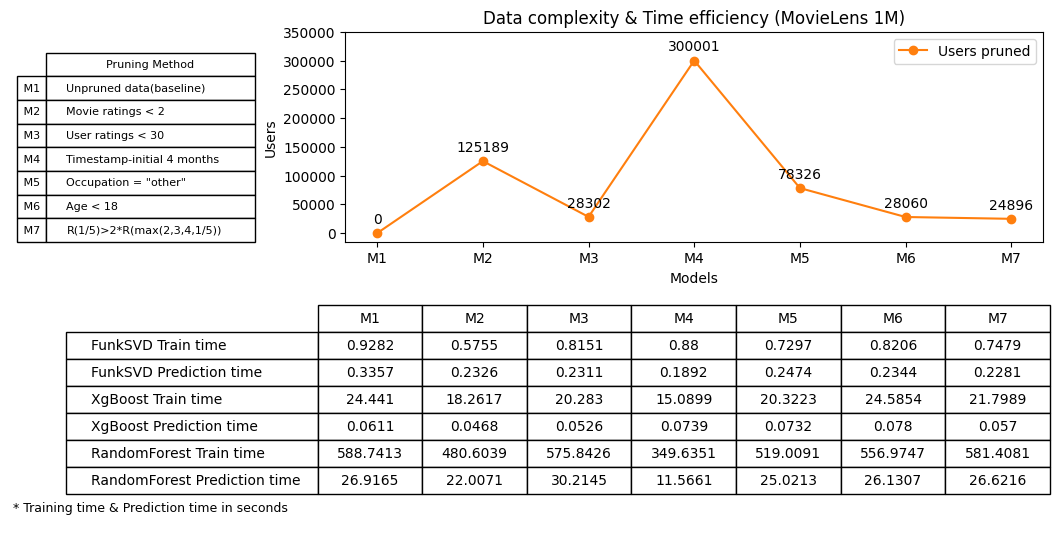

In [840]:
def visualization_data_time(n2, n3, n4, n5, n6, n7, tt1, tt2, tt3, tt4, tt5, tt6, tt7, tt8, tt9, tt10, tt11, tt12, tt13, tt14, tt15, tt16, tt17, tt18, 
tt19, tt20, tt21, pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9, pt10, pt11, pt12, pt13, pt14, pt15, pt16, pt17, pt18, pt19, pt20, pt21):
    
    x1 = np.array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6','M7'])

    n1 = 0

    y1 = np.array([n1, n2, n3, n4, n5, n6, n7])

    y2 = np.array([tt1, tt2, tt3, tt4, tt5, tt6, tt7])

    y3 = np.array([pt1, pt2, pt3, pt4, pt5, pt6, pt7])

    y4 = np.array([tt8, tt9, tt10, tt11, tt12, tt13, tt14])

    y5 = np.array([pt8, pt9, pt10, pt11, pt12, pt13, pt14])

    y6 = np.array([tt15, tt16, tt17, tt18, tt19, tt20, tt21])

    y7 = np.array([pt15, pt16, pt17, pt18, pt19, pt20, pt21])

    # Plot 1
    plt.figure(figsize=(9,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'Users pruned', color = '#ff7f0e')
    plt.title('Data complexity & Time efficiency (MovieLens 1M)')
    plt.yticks([0,50000,100000,150000,200000,250000,300000,350000])
    plt.ylabel('Users')
    plt.xlabel('Models')

    col_labels_model=['Pruning Method']
    row_labels_model=[' M1 ', ' M2 ', ' M3 ', ' M4 ', ' M5 ',' M6 ', ' M7 ']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 4 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))']]

    model_table = plt.table(cellText=model_vals,
          rowLabels=row_labels_model,
          colLabels=col_labels_model,
          cellLoc = 'left',
          fontsize = 25,
          loc='left', bbox=[-0.43, 0, 0.3, 0.9])

    for x,y in zip(x1,y1):
        label = y
        plt.annotate(label,
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,7),
                 ha='center')

    col_labels=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    row_labels=['FunkSVD Train time','FunkSVD Prediction time', 'XgBoost Train time','XgBoost Prediction time', 'RandomForest Train time', 'RandomForest Prediction time']
    table_vals= [[tt1, tt2, tt3, tt4, tt5, tt6, tt7],[pt1, pt2, pt3, pt4, pt5, pt6, pt7],
    [tt8, tt9, tt10, tt11, tt12, tt13, tt14],[pt8, pt9, pt10, pt11, pt12, pt13, pt14],
    [tt15, tt16, tt17, tt18, tt19, tt20, tt21],[pt15, pt16, pt17, pt18, pt19, pt20, pt21]]

    the_table = plt.table(cellText=table_vals,
          rowLabels=row_labels,
          colLabels=col_labels,
          cellLoc='center',
          fontsize = 30,
          loc='bottom', bbox=[-0.04, -1.2, 1.05, 0.9])

    plt.annotate('* Training time & Prediction time in seconds', 
            xy=(-0.28, 0), 
            xycoords=('axes fraction', 'figure fraction'),
            xytext=(0, 20),  
            textcoords='offset points',
            size=9, ha='center', va='bottom')
    
    plt.legend(loc = "upper right")
    plt.show()

visualization_data_time(n_m2, n_m3, n_m4, n_m5, n_m6, n_m7, tt_svd_m1, tt_svd_m2, tt_svd_m3, tt_svd_m4, tt_svd_m5, tt_svd_m6, tt_svd_m7, tt_xb_m1,
tt_xb_m2, tt_xb_m3, tt_xb_m4, tt_xb_m5, tt_xb_m6, tt_xb_m7, tt_rf_m1, tt_rf_m2, tt_rf_m3, tt_rf_m4, tt_rf_m5, tt_rf_m6, tt_rf_m7, pt_svd_m1, 
pt_svd_m2, pt_svd_m3, pt_svd_m4, pt_svd_m5, pt_svd_m6, pt_svd_m7, pt_xb_m1, pt_xb_m2, pt_xb_m3, pt_xb_m4, pt_xb_m5, pt_xb_m6, 
pt_xb_m7, pt_rf_m1, pt_rf_m2, pt_rf_m3, pt_rf_m4, pt_rf_m5, pt_rf_m6, pt_rf_m7 )

### Visualisation of RMSE & MAE of all models

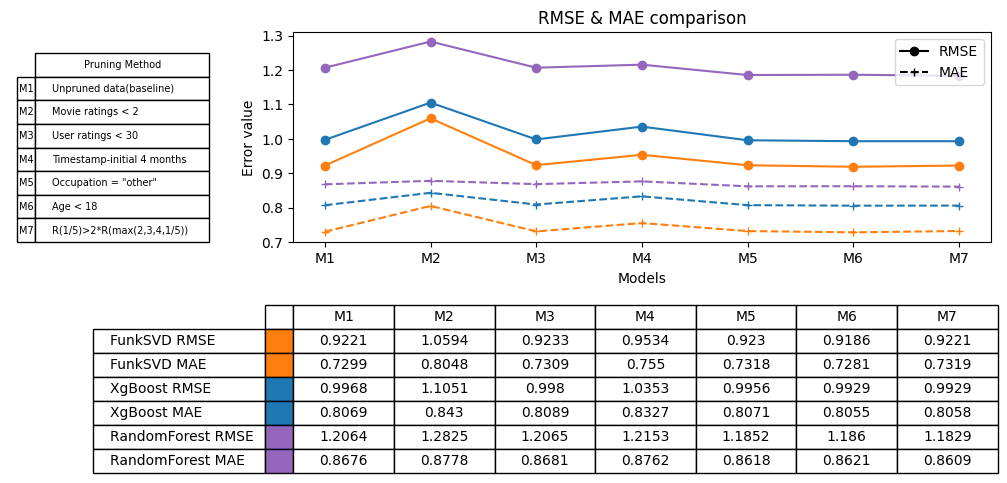

In [828]:
def visualization_model(rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7, mae_error, mae_error1, 
mae_error2, mae_error3, mae_error4, mae_error5, mae_m7, rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1, mae_error6, mae_error7, 
mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1, rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2,
mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2):
    
    x1 = np.array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6','M7'])
    y1 = np.array([rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7])

    y2 = np.array([mae_error, mae_error1, mae_error2, mae_error3, mae_error4, mae_error5, mae_m7])

    y3 = np.array([rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1])

    y4 = np.array([mae_error6, mae_error7, mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1])

    y5 = np.array([rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2])

    y6 = np.array([mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2])

    # Plot 1
    plt.figure(figsize=(9,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'RMSE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])
    plt.title('RMSE & MAE comparison')
    plt.ylabel('Error value')
    plt.xlabel('Models')

    #Plot 2
    plt.subplot(2,1,1)
    plt.plot(x1, y2, '+--', label = 'MAE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 3
    plt.subplot(2,1,1)
    plt.plot(x1, y3, 'o-', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 4
    plt.subplot(2,1,1)
    plt.plot(x1, y4, '+--', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 5
    plt.subplot(2,1,1)
    plt.plot(x1, y5, 'o-', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 6
    plt.subplot(2,1,1)
    plt.plot(x1, y6, '+--', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    col_labels=['','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    row_labels=['FunkSVD RMSE','FunkSVD MAE', 'XgBoost RMSE','XgBoost MAE', 'RandomForest RMSE', 'RandomForest MAE']
    colors_key_ = [["#ff7f0e","w","w","w","w","w","w","w"],["#ff7f0e","w","w","w","w","w","w","w"],["#1f77b4", "w","w","w","w","w","w","w"],["#1f77b4", "w","w","w","w","w","w","w"],
    ["#9467bd", "w","w","w","w","w","w","w"],["#9467bd", "w","w","w","w","w","w","w"]]
    table_vals= [['',rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7],['',mae_error, mae_error1, mae_error2, mae_error3, mae_error4, mae_error5, mae_m7],
    ['',rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1],['',mae_error6, mae_error7, mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1],
    ['',rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2],['',mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2]]

    #The first coordinate is a shift on the x-axis, second coordinate is a gap between plot and text box (table in your case), 
    # third coordinate is a width of the text box, fourth coordinate is a height of text box.

    the_table = plt.table(cellText=table_vals,
            cellColours=colors_key_,
          rowLabels=row_labels,
          colWidths = [0.07,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25],
          colLabels=col_labels,
          cellLoc='center',
          fontsize = 30,
          loc='bottom', bbox=[-0.04, -1.1, 1.05, 0.8])

    col_labels_model=['Pruning Method']
    row_labels_model=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 4 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))']]

    model_table = plt.table(cellText=model_vals,
          rowLabels=row_labels_model,
          colLabels=col_labels_model,
          cellLoc = 'left',
          fontsize = 25,
          loc='left', bbox=[-0.37, 0, 0.25, 0.9])

    row_labels_key=["", "", ""]
    colors_key = [["#ff7f0e","w"],["#1f77b4", "w"],["#9467bd", "w"]]
    key_vals = [['','FunkSVD'], ['','XgBoost'], ['','RandomForest']]

    legend_elements = [Line2D([0], [0], color='black', linestyle='-', marker='o'), Line2D([0], [0], color='black', linestyle='--', marker='+')]
    plt.legend(legend_elements,['RMSE','MAE'])
    plt.show()

visualization_model(svd_rmse_m1,svd_rmse_m2,svd_rmse_m3,svd_rmse_m4, svd_rmse_m5 ,svd_rmse_m6, svd_rmse_m7, svd_mae_m1,svd_mae_m2,svd_mae_m3,svd_mae_m4, 
svd_mae_m5 ,svd_mae_m6, svd_mae_m7, xb_rmse_m1,xb_rmse_m2,xb_rmse_m3,xb_rmse_m4, xb_rmse_m5 ,xb_rmse_m6, xb_rmse_m7, xb_mae_m1,xb_mae_m2,xb_mae_m3,xb_mae_m4, 
xb_mae_m5 ,xb_mae_m6, xb_mae_m7, rf_rmse_m1,rf_rmse_m2,rf_rmse_m3, rf_rmse_m4, rf_rmse_m5 ,rf_rmse_m6, rf_rmse_m7, rf_mae_m1,rf_mae_m2,rf_mae_m3,rf_mae_m4, 
rf_mae_m5 ,rf_mae_m6, rf_mae_m7)